In [2]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../../MIMIC-IV/PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
sys.path.append('../../utils')
from dataset_loader import TidySequentialDataCSVLoader
from collections import OrderedDict
from itertools import combinations
%matplotlib inline

## Get the test data and the specific units that people were admitted to 

In [3]:
ts_feature_cols = ['Heart Rate', 
                    'Respiratory Rate', 
                    'O2 saturation pulseoxymetry',
       'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic',
        'Temperature Fahrenheit',
        'Height (cm)',
       'Respiratory Rate (Total)', 
       'Potassium (serum)',
       'Sodium (serum)', 
        'Chloride (serum)', 
        'Hematocrit (serum)',
       'Hemoglobin', 
        'Creatinine (serum)', 
        'Glucose (serum)', 
        'Magnesium', 
       'Phosphorous', 
        'Platelet Count', 
        'Glucose (whole blood)',
        'Daily Weight', 
        'Absolute Neutrophil Count',
        'Prothrombin time',
        'Fibrinogen',
        'PH (Arterial)',
        'PH (Venous)',
        'HCO3 (serum)',
        'Arterial O2 pressure',
        'Arterial CO2 Pressure',
        'Lactic Acid',
        'Albumin',
        'Calcium non-ionized',
        'C Reactive Protein (CRP)',
        'ALT',
        'AST',
        'Direct Bilirubin', 
        'Total Bilirubin',
        'Troponin-T',
        'Venous CO2 Pressure']

dem_cols = ['Age', 'is_gender_male', 'is_gender_unknown']
id_col = ['stay_id']
id_cols = ['subject_id', 'hadm_id', 'stay_id']

feature_cols = ts_feature_cols+dem_cols

data_dir = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/mortality_prediction/'
y_test_df = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="in_icu_mortality",
    y_label_type='per_sequence'
)

test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)

In [3]:
test_x_NTD.shape

(10471, 24, 41)

In [4]:
y_test.shape

(10471,)

## Get the best PC-HMM mortality prediction model

In [4]:
# standardize data for PC-HMM
key_list = ['train', 'valid', 'test']
data_dict = dict.fromkeys(key_list)

X_test = np.expand_dims(test_x_NTD, 1)
data_dict['train'] = (X_test, y_test)
data_dict['valid'] = (X_test, y_test)
data_dict['test'] = (X_test, y_test)
data = custom_dataset(data_dict=data_dict)

model_dir = '/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/mortality_prediction/'
best_model_weights = os.path.join(model_dir, 
                                  'semi-supervised-pchmm-lr=0.005-seed=123819-init_strategy=kmeans-batch_size=128-perc_labelled=100-predictor_l2_penalty=0-n_states=5-lamb=100-weights.h5')
n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])

model = HMM(states=n_states,
            observation_dist='NormalWithMissing',
            predictor_dist='Categorical')

model.build(data)
model.model.load_weights(best_model_weights)

x_test, y_test = data.test().numpy()
z_test = model.hmm_model.predict(x_test)

Class dist 0.08356412950052526
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


In [6]:
n_states

5

In [4]:
model._predictor.get_weights()

[array([[-0.33206993, -0.48186585],
        [-5.7248755 ,  7.154169  ],
        [-3.9686112 ,  3.4438372 ],
        [ 2.9941235 , -3.8432844 ],
        [ 1.6208067 , -2.6090124 ]], dtype=float32),
 array([-0.08112375, -1.6656978 ], dtype=float32)]

## Get the learned means and covariances of the 5 pc-hmm states for various covariates

In [5]:
def plotGauss2DContour(
        mu, Sigma,
        color='b',
        radiusLengths=[1.0, 3.0],
        markersize=3.0,
        ax_handle=None,
        label=''
        ):
    ''' Plot elliptical contours for provided mean mu, covariance Sigma.
    Uses only the first 2 dimensions.
    Post Condition
    --------------
    Plot created on current axes
    '''
    
    # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
    lambda_D, U_DD = np.linalg.eig(Sigma)
    
    # Verify orthonormal
    D = len(mu)
    assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
    # View eigenvector matrix as a rotation transformation
    rot_DD = U_DD

    # Prep for plotting elliptical contours
    # by creating grid of G different (x,y) points along perfect circle
    # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
    unit_circle_radian_step_size=0.03
    t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
    x_G = np.sin(t_G)
    y_G = np.cos(t_G)
    Zcirc_DG = np.vstack([x_G, y_G])

    # Warp circle into ellipse defined by Sigma's eigenvectors
    # Rescale according to eigenvalues
    Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
    # Rotate according to eigenvectors
    Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)

#     radius_lengths=[0.3, 0.6, 0.9, 1.2]
    radius_lengths=[1.0, 2.0, 3.0]

    # Plot contour lines across several radius lengths
    for r in radius_lengths:
        Z_DG = r * Zrotellipse_DG + mu[:, np.newaxis]
        ax_handle.plot(
            Z_DG[0], Z_DG[1], '.-',
            color=color,
            markersize=3.0,
            markerfacecolor=color,
            markeredgecolor=color, 
            label=label)
        
    return ax_handle

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(0.99, 1.05))
    return ax

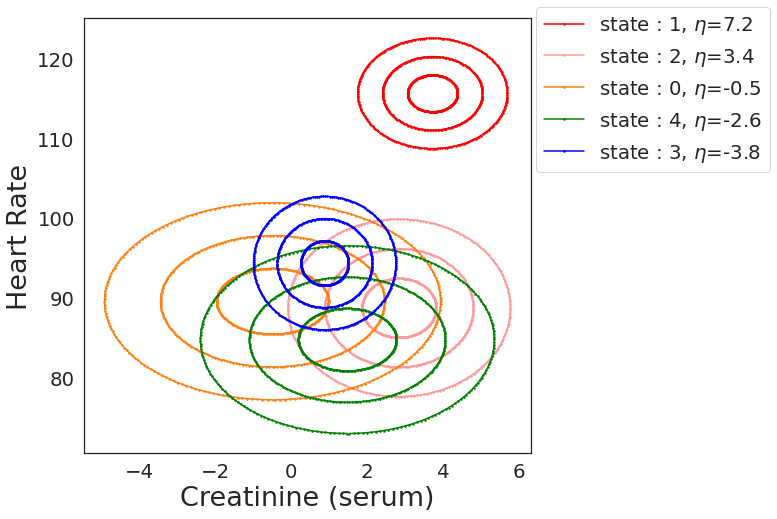

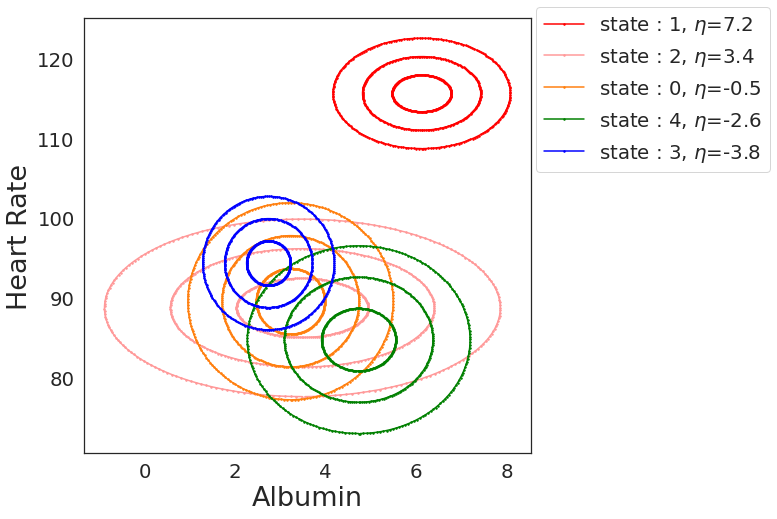

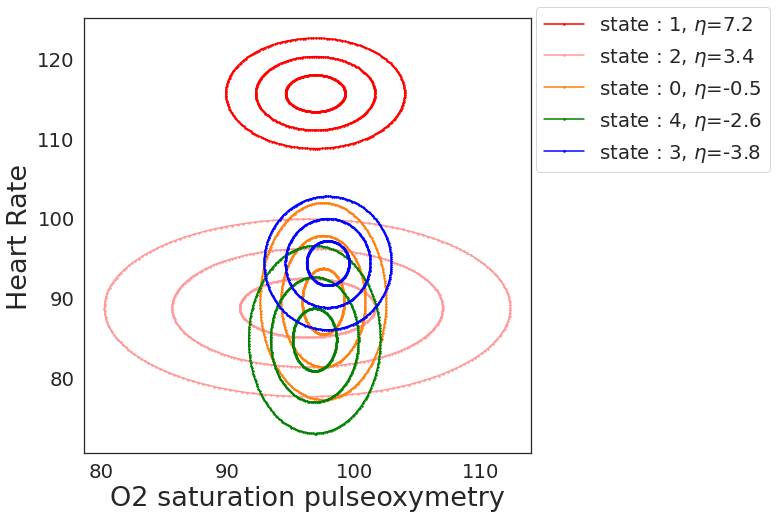

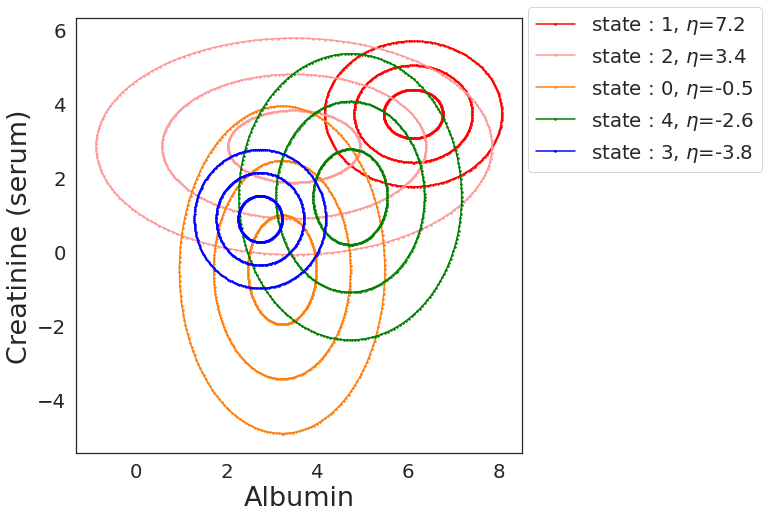

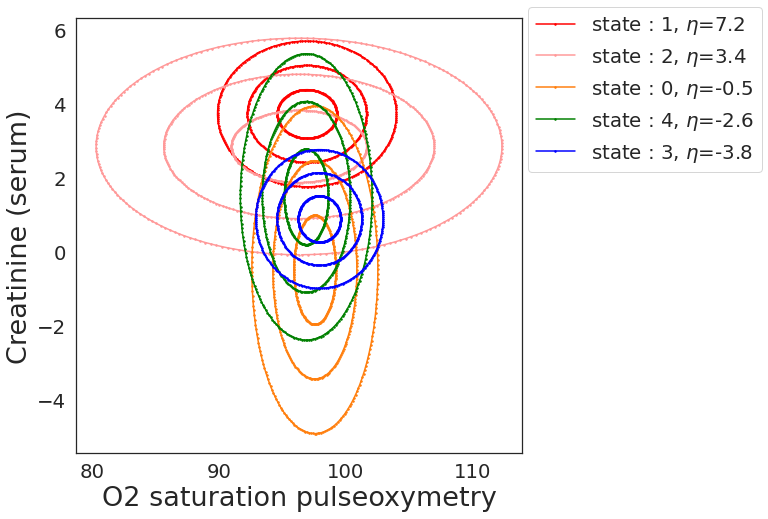

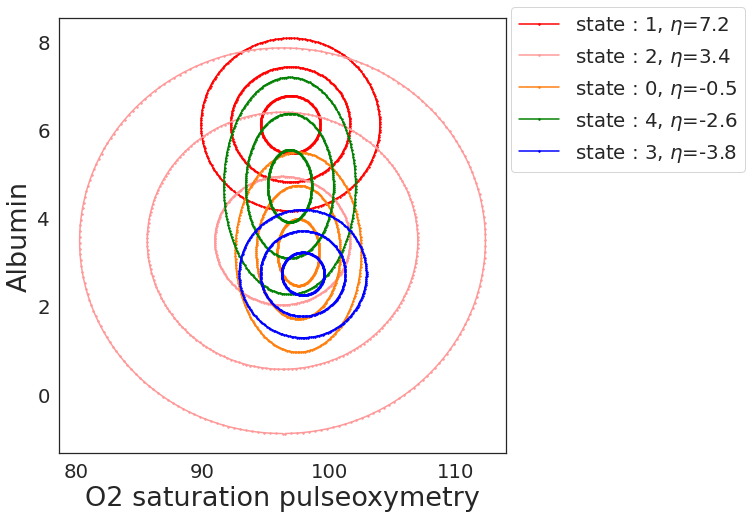

In [8]:
mu_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.mean().numpy()
cov_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.scale.numpy()
predictor_weights_K = np.squeeze(model._predictor.get_weights()[0][:, 1])
sorted_inds = np.argsort(predictor_weights_K)[::-1] #np.array([4, 0, 3])
keep_features_cols = ['Heart Rate', 'Creatinine (serum)', 'Albumin', 'O2 saturation pulseoxymetry']

# keep_features_inds = np.where(np.isin(feature_cols, keep_features_cols))


keep_features_inds = [feature_cols.index(ii) for ii in keep_features_cols]
n_influential = 5 # number of influential states to retain from predictor
mu_KD_influential = np.squeeze(mu_all[sorted_inds[:n_influential], :][:, keep_features_inds])
cov_KD_influential = np.squeeze(cov_all[sorted_inds[:n_influential], :][:, keep_features_inds])
feature_cols_reindexed = np.array(feature_cols)[keep_features_inds[0]]

state_colors = ['r', '#FF9999', 'tab:orange', 'g', 'b']
# cohort_names = ['z=4 (Risk state)', 'z=0 (Risk state)', 'z=3 (Normal)']
for combo in combinations(keep_features_cols, 2):
    f, axs = plt.subplots(1, 1, figsize=(8, 8))
    sns.set_style("white") # or use "white" if we don't want grid lines
    sns.set_context("notebook", font_scale=1.8)
    curr_feature_combo_inds = np.isin(keep_features_cols, combo)
    curr_feature_combo = np.array(keep_features_cols)[curr_feature_combo_inds]
    for kk in range(n_influential):
        mu = mu_KD_influential[kk, curr_feature_combo_inds][::-1]
        Sigma = np.diag(cov_KD_influential[kk, curr_feature_combo_inds][::-1])
        axs = plotGauss2DContour(mu, Sigma, ax_handle=axs, 
                                 label=r'state : %s, $\eta$=%.1f'%(sorted_inds[kk], 
                                                                   predictor_weights_K[sorted_inds[kk]]), 
                                 color=state_colors[kk]
                                )

    axs.legend()
    fontsize=27
    axs = legend_without_duplicate_labels(axs)
    axs.set_xlabel(curr_feature_combo[1], fontsize=fontsize)
    axs.set_ylabel(curr_feature_combo[0], fontsize=fontsize)
    f.savefig('interpretability_%s_%s_MIMIC.pdf'%(curr_feature_combo[0], 
                                                 curr_feature_combo[1]), 
              bbox_inches='tight', 
              pad_inches=0)

## Plot the average beliefs for mort=1 vs mort=0 patients

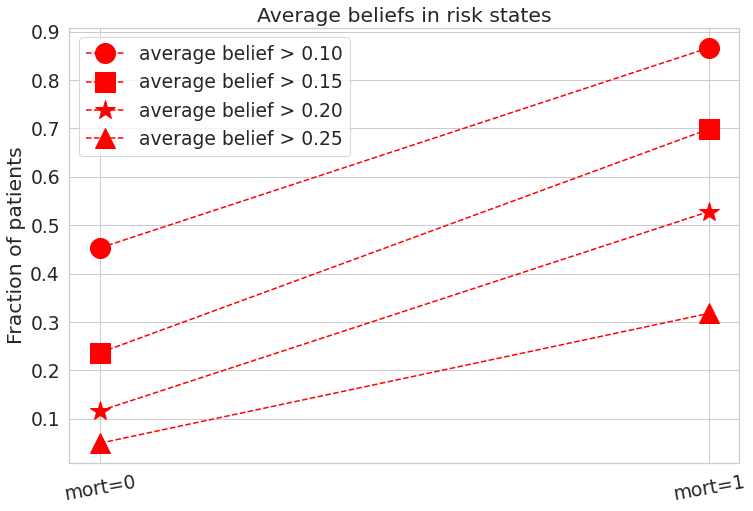

In [63]:
N, T, K = z_test.shape
bins = np.arange(0, 1, 0.05)
mort_list = ['mort=0', 'mort=1']
f, axs = plt.subplots(1, 1, 
                      figsize=(12, 8),
                     )
sns.set_style("whitegrid") # or use "white" if we don't want grid lines
sns.set_context("notebook", font_scale=1.7)
perf_dict_list = []
min_belief_list = [0.1, 0.15, 0.2, 0.25]
state_names = ['risk', 'normal']
risk_state_inds = [1, 2]

for mort_label in [0, 1]:
    for min_belief in min_belief_list:
    
        curr_inds = y_test_df['in_icu_mortality']==mort_label
        curr_label_z_test_NTK = z_test[curr_inds]
        curr_label_avg_belief_NK = np.mean(curr_label_z_test_NTK, axis=1)
        
        curr_N = curr_label_avg_belief_NK.shape[0]
        
        frac_n_high_beliefs = (curr_label_avg_belief_NK[:, risk_state_inds]>=min_belief).sum()/curr_N
        perf_dict_list.append({'state' : 'risk',
                              'min_belief' : min_belief,
                              'frac_n_high_beliefs' : frac_n_high_beliefs,
                              'mort_category' : mort_list[mort_label]})

beliefs_perf_df = pd.DataFrame(perf_dict_list)

marker_list = ['o', 's', '*', '^']
for jj, min_belief in enumerate(min_belief_list):
    curr_inds = (beliefs_perf_df.state=='risk')&(beliefs_perf_df.min_belief==min_belief)
    risk_state_avg_beliefs_per_los = beliefs_perf_df.loc[curr_inds, 'frac_n_high_beliefs'].values
    axs.plot(risk_state_avg_beliefs_per_los, marker=marker_list[jj], linestyle='--', 
             color='r', markersize=20, label='average belief > %.2f'%min_belief)
    axs.set_xticks(np.arange(0, 2))
    axs.set_xticklabels(beliefs_perf_df.loc[curr_inds, 'mort_category'].values, rotation=10)
    axs.set_title('Average beliefs in risk states')
#     axs.set_yscale('log')
    axs.set_ylabel('Fraction of patients')
#     yticks = np.arange(0, .5, 0.1)
#     axs.set_yticks(yticks)
#     axs.set_yticklabels(['%.2f'%rr for rr in yticks])
#     axs.set_ylim([-.4, 1])
axs.legend()
plt.show()
f.savefig('avg_beliefs_plots_for_mortality.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

## Show the beliefs of at risk and normal patients

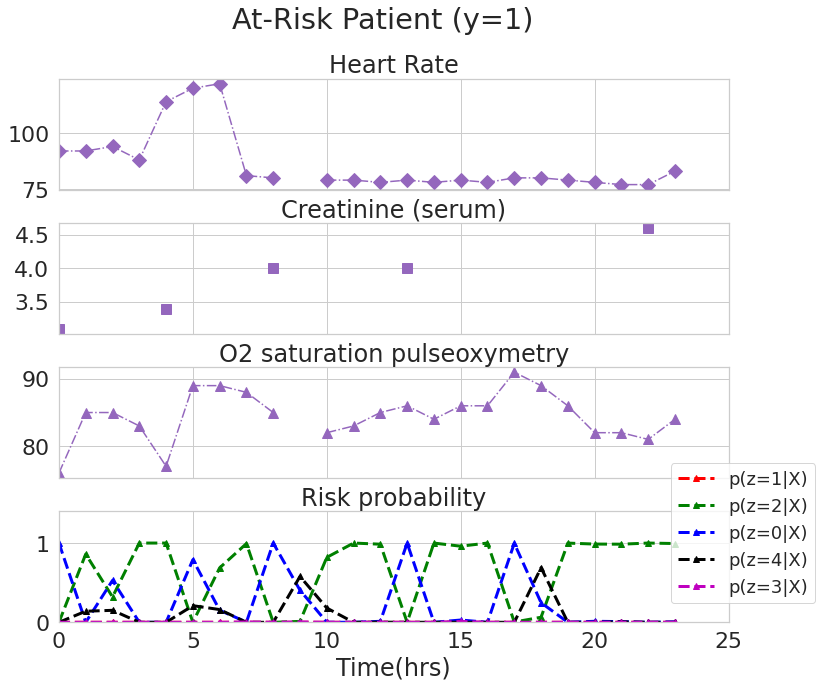

In [60]:
curr_idx = 6252#6227#9956
curr_beliefs = np.squeeze(np.asarray(z_test[curr_idx]))
keep_features_cols = ['Heart Rate', 'Creatinine (serum)', 'O2 saturation pulseoxymetry']
keep_features_inds = [feature_cols.index(ii) for ii in keep_features_cols]
features_inds_dict = dict(zip(keep_features_cols, keep_features_inds))

markers = ['D', 's', '^', 'x']
colors = ['tab:purple', 'tab:purple', 'tab:purple', 'tab:purple']

T = np.arange(0, 24)

f, axs = plt.subplots(len(keep_features_cols)+1, 1, figsize=(12, 10), sharex=True)
sns.set_style("whitegrid") # or use "white" if we don't want grid lines
sns.set_context("notebook", font_scale=2.0)
for ii, (feat, ind) in enumerate(features_inds_dict.items()):
    axs[ii].plot(T, X_test[curr_idx, 0, :, ind], linestyle='-.', marker=markers[ii], color=colors[ii], 
                 markersize=10)
    axs[ii].set_title(feat)
    
axs[-1].set_title('Risk probability')
    
for kk in range(5):
    axs[-1].plot(T, curr_beliefs[:, sorted_inds[kk]], marker='^', color=state_colors[kk], 
                 label='p(z=%s|X)'%sorted_inds[kk], linestyle='--', linewidth=3)

axs[-1].legend(fontsize=18, 
               bbox_to_anchor=(0.9, 0.09))


axs[-1].set_xlabel('Time(hrs)')
axs[-1].set_ylim([0., 1.4])
axs[-1].set_xlim([0., 25.])
plt.suptitle('At-Risk Patient (y=1)')
# f.tight_layout()
f.savefig('mortality_risk_patient_interpretability.pdf', bbox_inches='tight', pad_inches=0)
plt.subplots_adjust(hspace=0.3)

In [59]:
dict(zip(keep_features_cols, keep_features_inds))

{'Heart Rate': 0,
 'Creatinine (serum)': 13,
 'Albumin': 29,
 'O2 saturation pulseoxymetry': 2}

In [71]:
np.flatnonzero(y_test==1)

array([    0,     2,     5, ..., 20936, 20938, 20941])

In [24]:
risk_state_avg_beliefs = np.mean(z_test[:, :, 2], axis=-1)
np.argsort(risk_state_avg_beliefs, axis=-1)[::-1][:20]

array([ 4992,  6434,  6227,  6252,  3855,  9783,  3145,  9155,  6861,
        1019, 10115,  3377,  4526,  4703,  6766,  1753,  6887,  9140,
        3176,  8642])

In [25]:
for jj in np.argsort(risk_state_avg_beliefs, axis=-1)[::-1]:
    kill_inds = np.flatnonzero(y_test[:, 1]==1)
    if jj in kill_inds:
        print(jj)

6227
6252
3855
9155
6861
1019
10115
3377
4526
6766
1753
6887
3176
8642
5098
4060
2335
341
8114
6452
2
6203
816
5332
404
1213
6858
7682
1303
6727
5483
3043
1793
1192
6894
6341
1787
479
2031
9000
9699
6506
7961
2462
6601
5083
8580
6400
7990
6605
745
4131
3410
6040
9295
8853
1366
7144
3120
5309
3341
8711
1822
1596
9510
6831
1866
9099
6006
6251
8689
8912
6975
6190
4666
5534
5423
8943
10133
4414
2431
5238
9071
8933
8655
127
5278
10182
10131
8924
627
1429
5040
673
3545
9580
8261
3438
7546
2820
656
2341
2147
1341
5506
10465
8911
8308
1108
7549
8505
5357
6587
6738
3875
2474
9492
2370
6699
866
5587
6266
10272
828
10382
5832
7010
9663
4554
8643
7337
9369
1402
133
9446
918
193
1314
4360
7482
4807
3532
5258
488
4203
1345
3347
4543
1486
7087
6807
9482
8010
8593
5725
2650
2413
8675
6948
1967
9528
1319
8717
1570
6180
4630
261
6189
5438
1648
1752
9490
5492
8832
7242
9474
2604
3522
1048
5142
7250
2936
8934
3296
1383
8365
498
192
1238
2035
6144
418
1892
3580
3695
9679
94
10289
8392
3692
3596
6537
8878
1

In [30]:
features_inds_dict

{'Heart Rate': 0, 'Creatinine (serum)': 13, 'O2 saturation pulseoxymetry': 29}

In [31]:
feature_cols[29]

'Albumin'